# <font color=#14F278> 0. Introduction</font>

##### This project will take the Boston Housing dataset and use it to predict the median value of owner-occupied homes. This goal will be broken down into three tasks:
##### - Task 1: Use sklearn to implement a gradient boosted trees model
##### - Task 2: Implement a gradient boosted trees model from scatch
##### - Task 3: Conduct EDA (explatory data analysis) to select the features and settings that perform best.

# <font color=#14F278> 1. Exploratory Data Analysis (EDA) - Task 3</font>

##### Introduction to task.
##### Domain knowledge and overview of data (add more detail here later)
##### Ethical Considerations:
##### The B column refers to the proportion of black population by town. It is the only racial statistic included in the the dataset, showing clear racial targeting. The authors included this column because they assumed that racial self-segreration had a parabolic positive impact on housing prices. However researchers have shown that consensus data from the time does not support this, making it a clear example of bias in data. This assumption is harmful and if this dataset was used in any scenario outside of a training example it would lead to econmic inequalities for people of color. For these reasons it was not even considered as one of our selected features. 

#### The code below will take you through our initial data analysis and how we selected what preprocessing needed to be done before we performed gradient boosted tree regression.

In [1]:
# Libraries and modules we will need for all 3 Tasks are listed here
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
# All sklearn functions below are for task 1 and 3, they are not used in task 2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## <font color=#14F278>1.1 Initial Data Analysis: Nulls, Distributions, etc

In [3]:
#Upload data in dataframe
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv('housing.csv', sep = '\s+', header = None, names = column_names)
df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
# Check data for nulls, correct data types, etc
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


## <font color=#14F278> 1.2 Domain knowledge</font>
#### Our data set consists of data from the greater Boston metro area in the 1970s, with each row representing the resutls of a single municipality. There are a total of 14 columns, including 13 features and 1 target column, MEDV, which represents the median value in $1,000s of a home in each town. Notably, the MEDV column has values that are truncated at 50.0 - i.e. any value greater than 50 becomes 50.  There are 506 rows of data, with no nulls, and all columns are float values except CHAS and RAD (which are integers). The column descriptors are listed below: 
 - ZN: proportion of residential land zoned for lots over 25k sq. ft.
 - INDUS: proportion of non-retail business acres per town
 - CHAS: Charles River dummy variable - 1=if tract bounds river
 - NOX: nitric oxides concentration (parts per 10 mill)
 - RM: average number of rooms per dwelling
 - AGE: proportion of owner-occupied units built prior to 1940
 - DIS: weighted distances to 5 Boston employment centres
 - RAD: index of accessibility to radial highways
 - TAX: full-value property-tax rate per 10k USD
 - PTRATIO: pupil-to-teacher ratio by town
 - B: 1000(Bk-0.63)^2 where Bk is the proportion of black population by town
 - LSTAT: % lower status of the population
 - MEDV: Median Value of owner-occupied homes in $1000's


### Feature Selection: Correlation Heatmap, Outlier Analysis 

#### Correlation Map: (note that this heatmap depicts the amplitude of correlation)

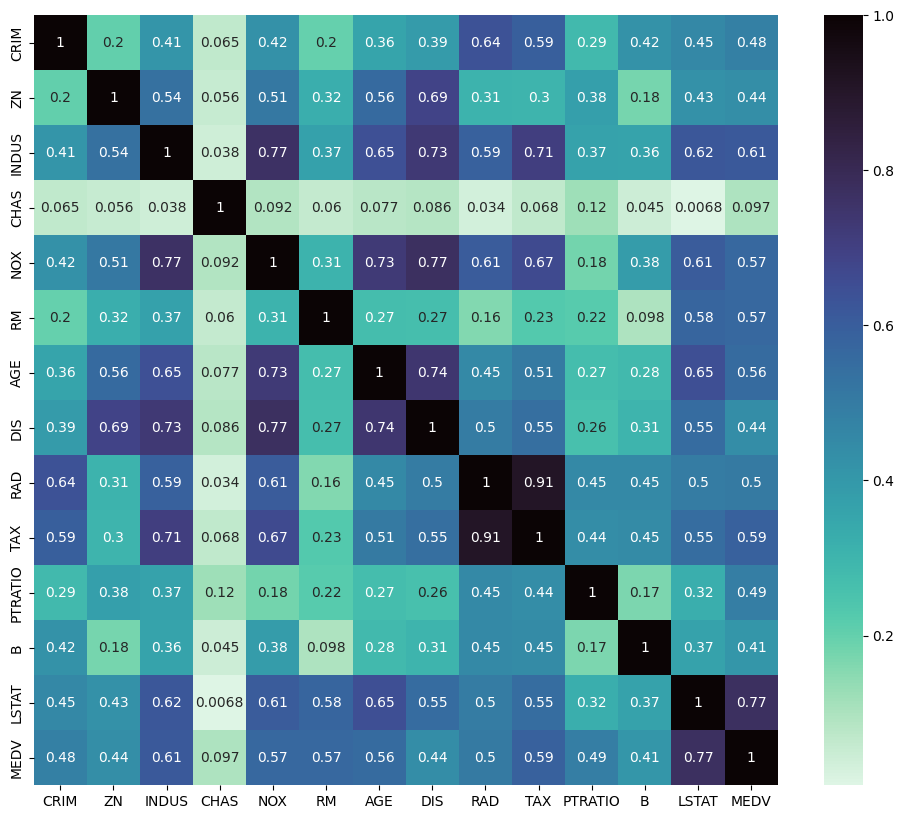

In [32]:
df_corr = abs(df.corr())
fig, ax = plt.subplots(figsize= (12,10))
g = sns.heatmap(df_corr, annot=True, ax=ax, cmap = 'mako_r' )
plt.show()


#### Looking at the correlation map, it is clear that some features are more highly correlated with MEDV than others. LSTAT and INDUS stand out immediately as highly correlated while many other features have medium levels of correlation. However, we may also notice that many of these features are highly correlated with one another - for instance, TAX shares a medium correlation with MEDV, but high correlations with CRIM, NOX, AGE, DIS, and RAD. This tells us that only one of these should be included in our final feature selection, to avoid redundancy. Because of the high degree of multicollinearity within the data, we also ran a Lasso Regularization Regression to help identify some features which may be more or less useful. 

In [40]:
from sklearn import linear_model
X = df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)
reg.predict(X_test)

for i in range(len(reg.coef_)):
    print(df.columns[i], reg.coef_[i])

CRIM -0.10226698271720312
ZN 0.03989715920233452
INDUS -0.09347155855931982
CHAS 0.0
NOX -0.0
RM 2.0267880443075494
AGE -0.033731698451440514
DIS -0.8439126175283435
RAD 0.18466619995730976
TAX -0.012361035311302247
PTRATIO -0.5221475696588187
B 0.007353565902341065
LSTAT -0.3696712501103638


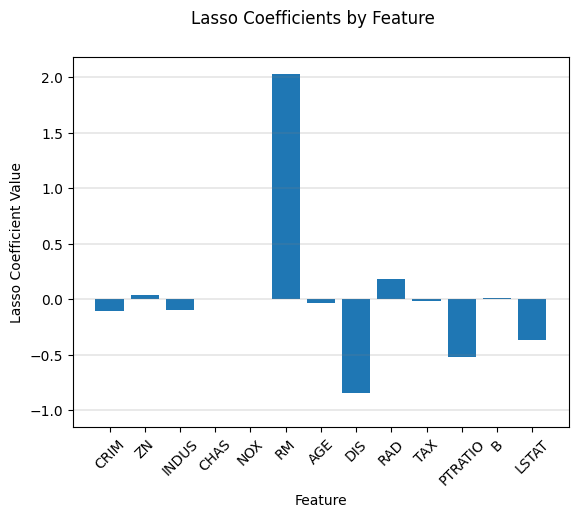

In [70]:
plt.bar(X.columns, reg.coef_)
plt.xticks(rotation = 45)
plt.ylabel('Lasso Coefficient Value')
plt.xlabel('Feature')
plt.suptitle('Lasso Coefficients by Feature')
for i in range(-2, 5):  # Adjust range as needed
    plt.axhline(i * 0.5, color='gray', linestyle='-', linewidth=0.25)
plt.show()

#### The above Lasso Regression reveals that some features, such as RM, DIS, PTRATIO, and LSTAT should be strongly considered for inclusion in our final feature list while others such as CHAS and NOX should be disregarded entirely. Via extensive testing on linear regressions of different feature combinations, we discovered that the combination that produced the best results was: 
### **INDUS, RM, TAX, PTRATIO, LSTAT**

#### Conclusions: 

##### - MEDV has a strong correlation with...
##### - But we can see that *list features here* are strongly correlated, so we only need to use...
##### - Any other things we get from this figure

## <font color=#14F278>1.3 Outliers Analysis:</font>

##### Two types of data points will be considered in this section, outliers and high leverage points. Outliers are data points whose target feature significantly deviate from the rest of the data, this is defined as any point 1.5 times the inter-quartile range above the upper quartile or below the lower quartile. Meanwhile high leverage points are data points with extreme predictor values in the feature space. High leverage points are often considered as outliers in the predictor space (i.e. the input features).
##### Outliers and high leverage points need to be considered when preprocessing data, as they can cause overfitting and distort the variability of the data. When deciding what to do with outliers we need to look at our ML model. Gradient Boosted Regression Trees use thresholding on input features for decisions, and the success of this threshold is calculated with a weighted sum of the variance between the observed and predicted value of the target feature. 
##### As the output features are optimized with variance and its performance evaluated with MSE, both of which use a sum of square, this means that outliers within the target feature will have exponentially larger residuals, which will disproportionately focus the model on these points. For this reason we need to get rid of the outliers on our target feature MEDV. 

### Identification:

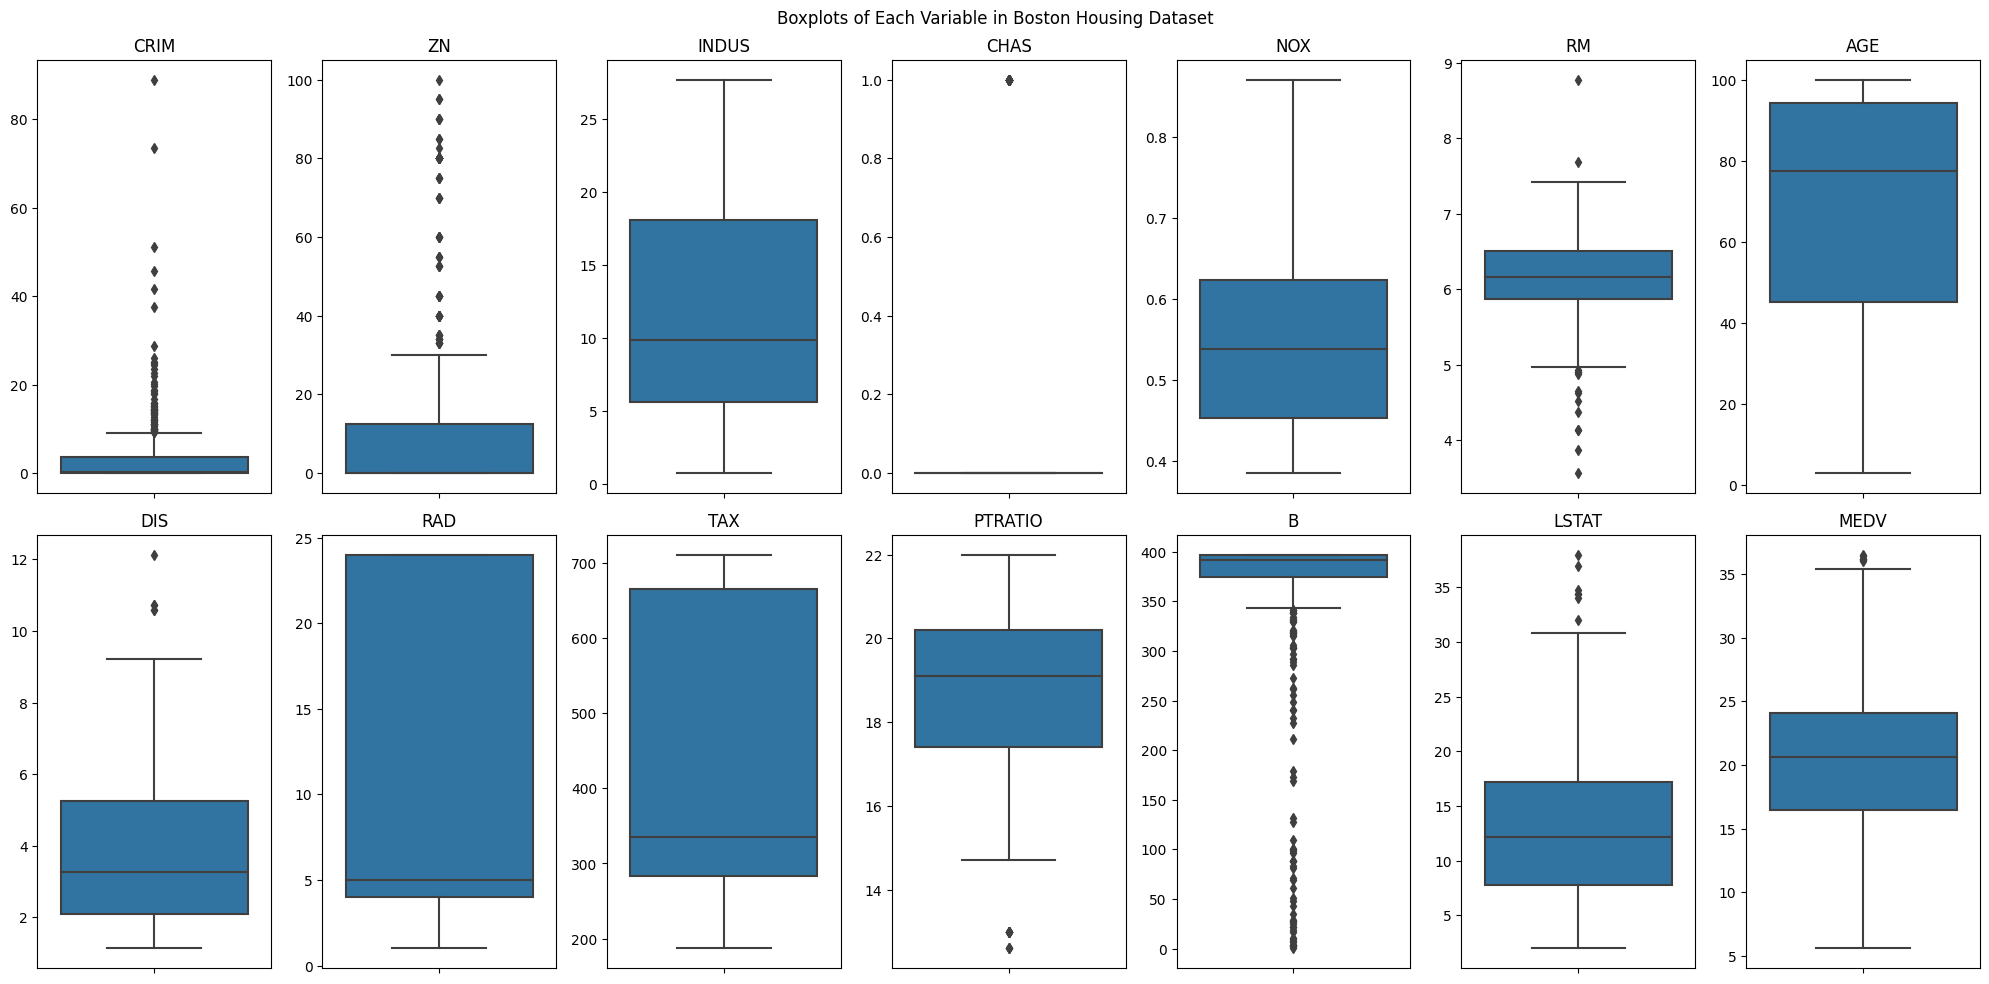

In [68]:
#Box Plot of every column in the data
fig, ax = plt.subplots(ncols = 7, nrows = 2, figsize = (20,10))
ax=ax.flatten()
index = 0
for i,j in df.items():
    sns.boxplot(y=i, data = df, ax=ax[index])
    ax[index].set_title(i)
    ax[index].set_ylabel('')
    index+=1
plt.suptitle('Boxplots of Each Variable in Boston Housing Dataset')
plt.tight_layout()


In [5]:
# Outliers count, percentage of outliers in each column
for i,j in df.items():
    q1 = j.quantile(0.25) # Lower quartile range
    q3 = j.quantile(0.75) # Upper quartile range
    iqr = q3-q1 # Interquartile range (IQR)
    # Outlier is defined as anything 1.5x the IQR from the lower or upper quartile range
    outliers = j[(j<=q1-1.5*iqr) | (j>=q3+1.5*iqr)]
    p = np.shape(outliers)[0] * 100/np.shape(df)[0]
    print(i,p)


CRIM 13.043478260869565
ZN 13.438735177865613
INDUS 0.0
CHAS 100.0
NOX 0.0
RM 5.928853754940712
AGE 0.0
DIS 0.9881422924901185
RAD 0.0
TAX 0.0
PTRATIO 2.964426877470356
B 15.217391304347826
LSTAT 1.383399209486166
MEDV 7.905138339920948


## <font color=#14F278>1.4 Outlier Removal:</font>

In [6]:
def outlier_removal(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """Removes rows with outliers in a particular column

    Args:
        df (pandas DataFrame): The DataFrame we want the values removed from
        column (str): The column we're checking for outliers

    Returns:
        df (pandas DataFrame): The DataFrame minus the outliers
    """
    # Calculate IQR
    upper_QR = df[column].quantile(0.75)
    lower_QR = df[column].quantile(0.25)
    inter_QR = upper_QR-lower_QR
    # Filter for outliers
    df = df[df[column]<(upper_QR+(1.5*inter_QR))] # Gets all values below upper outlier limits
    df = df[df[column]>(lower_QR-(1.5*inter_QR))] # Gets all values above lower limits
    # Reset indexes 
    df.reset_index(drop=True)
    
    return df


In [7]:
# Remove Outliers
df = outlier_removal(df, "MEDV")
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 466 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     466 non-null    float64
 1   ZN       466 non-null    float64
 2   INDUS    466 non-null    float64
 3   CHAS     466 non-null    int64  
 4   NOX      466 non-null    float64
 5   RM       466 non-null    float64
 6   AGE      466 non-null    float64
 7   DIS      466 non-null    float64
 8   RAD      466 non-null    int64  
 9   TAX      466 non-null    float64
 10  PTRATIO  466 non-null    float64
 11  B        466 non-null    float64
 12  LSTAT    466 non-null    float64
 13  MEDV     466 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 54.6 KB
None


#### Summary: 

##### Removing all outliers in the MEDV (which were 7.9% of the data), results in having our dataset reduced to 466 rows. This decision will help prevent overfitting within the model.

# <font color=#14F278>2. Gradient Boosted Tree Regression with sklearn - Task 1</font>

#### This task will cover the implementation of a gradient boosted tree ML model using the sklearn library, but first some background on what gradient boosted decision trees are:

## <font color=#14F278>2.1 Decision Trees:</font>

#### A model made of decision and leaf nodes, where the decision nodes represents a threshold based on a feature, and leaf nodes are an endpoint. Decision nodes branch off into a split based on the feature. 
#### The ML proponent of this model is optimizing the best threshold to split the data on for each decision node. Which is done with a greedy method called Binary Recursive Partioning which in regression instances uses the weighted sum of variance across both child nodes as the cost function it's minimizing.

#### Introduction to sklearn's model and its components (Decision Trees), hyperparameters we needed to consider, and any other coding specific additions we kept in mind.

#### The code below will take you through our implementation with sklearn.  

## <font color=#14F278> 2.2 Gradient boosting:</font>
#### Gradient boosting is a model ensemble that allows a number of different decision trees to be combined into one model. Gradient boosting starts training a 'weak learner' - a decision tree, typically with few nodes - then makes predictions based on the training data, which are recorded as the remainder. The next model is then trained with the remainder as the target space, and the process continues. Gradient boosting helps increase the efficiency of your model by correcting errors and is robust to overfitting due to each individual tree being relatively small - it also can deal well with high leverage points due to the nature of the nodes splitting on threshold and small tree size. 

## <font color=#14F278> 2.3 GridSearchCV </font>

#### ex

## <font color=#14F278> 2.4 Sklearn Implementation</font>

In [8]:
# Split Data into our inputs (X) and output (y) with only our selected features
X = df[['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT']]
y = df['MEDV']

# Split data further into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=12)

# Create our model
model = GradientBoostingRegressor()
# Implement GridSearchCV to optimize hyper-parameters
params = {'min_samples_leaf':[1,5,10,15,20,25,30], 'max_depth':[2,3,4,5,6,7,8,9,10]} # Params for it to cycle through
clf = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring= 'r2')
# Fit model
clf.fit(X_train, y_train)
# Make predictions
y_pred = clf.predict(X_test)
# Print model performance metrics
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
print(clf.best_params_)


MSE: 7.426365444386634
MAE: 2.230963895220341
R2: 0.841519835458707
{'max_depth': 3, 'min_samples_leaf': 15}


## <font color=#14F278>2.5 Principal Component Analysis (PCA):</font>

#### We wanted to further validate using feature selection over feature transformations by comparing the model results from our chosen features with model results from a Principal Component Analysis. 
#### The reason for this is PCA is an unsupervised learning method and dimensionality reduction techique that aims to decrease the number of variables while preserving the maximum amount of information possible. It does this by constructing new variables (principal components) which maximize the amount of variance. 
#### As R2 is the percentage of the variance in the target features that is accounted for by the input features, comparing our above model metrics to the R2 of a model trained on the principal components will tell us a lot about the level of information our feature selection is preserving. 

In [10]:
# Split into X and y (df has already had outliers removed)
pca_x = df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']]
pca_y = df['MEDV']
pca_x.reset_index(drop=True)
pca_y.reset_index(drop=True)

# Standardize Data (Very important for PCA) 
scaler = StandardScaler()
pca_scaled = pd.DataFrame(scaler.fit_transform(pca_x))
pca_scaled.reset_index(drop=True)

# Perform PCA
pca = PCA(n_components=4) # Init model
pca.fit(pca_scaled) # Fit to model
pca_data = pca.transform(pca_scaled) # Transform data
pca_data = pd.DataFrame(pca_data, columns = ['PC1', 'PC2', 'PC3', 'PC4']) # Put into DataFrame
pca_data.head()

,PC1,PC2,PC3,PC4
0,-2.195742,-0.673019,0.618541,0.149691
1,-1.504879,-0.715335,-0.336655,-0.609984
2,-2.196014,-0.310891,0.646827,-1.445304
3,-2.745419,0.131020,0.237685,-1.466286
4,-2.583865,0.070160,0.329458,-1.483547


<Axes: >

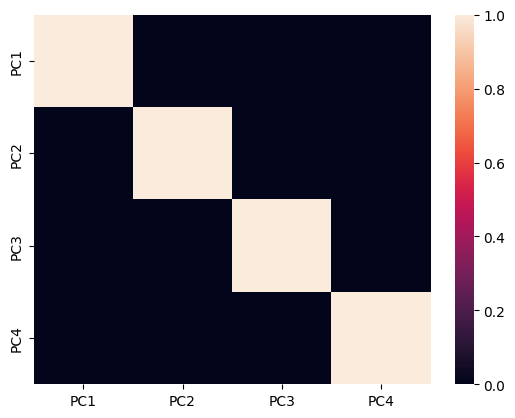

In [11]:
# Correlation between features after PCA
sns.heatmap(pca_data.corr())

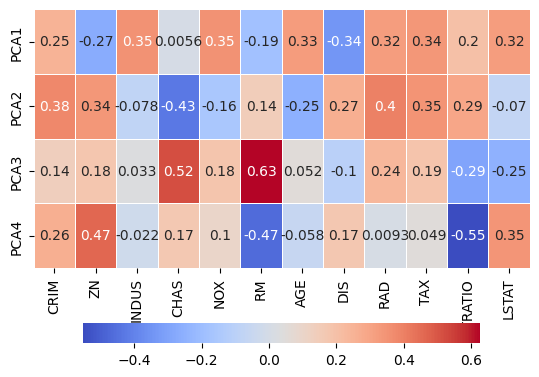

In [12]:
# Composition of each PC
fig, ax = plt.subplots()

ax = sns.heatmap(
    pca.components_,
    cmap = "coolwarm",
    yticklabels=[f"PCA{x}" for x in range(1,pca.n_components_+1)],
    xticklabels = list(pca_x.columns),
    annot=True,
    linewidths=.5,
    cbar_kws={"shrink":.8, "orientation": 'horizontal'}
)
#ax.set_aspect("equal")
plt.show()

In [22]:
# Split the data 
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_data, pca_y, test_size=.2, random_state=12)

# Create, Train, Fit, and Predict with the 
clf_pca = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring= 'r2')
clf_pca.fit(pca_X_train, pca_y_train)
pca_predictions = clf_pca.predict(pca_X_test)

# Print model metrics
print("MSE:", mean_squared_error(pca_y_test, pca_predictions))
print("MAE:", mean_absolute_error(pca_y_test, pca_predictions))
print("R2:", r2_score(pca_y_test, pca_predictions))
print(clf_pca.best_params_)


MSE: 11.163914194757398
MAE: 2.609110588483568
R2: 0.7617597771400599
{'max_depth': 3, 'min_samples_leaf': 1}


#### Summary:

##### Our selected features returned a well trained model and this result was validated by comparing the model performance metrics to a model trained on data that had undergone PCA. The R2 score from our feature selected model is .878 while our PCA model is .762, showing that our selected features actually performed better than data that has undergone PCA. 

##### This could be for a vairety of reasons, the correlation between the features could be too weak. We know there are a few highly correlated features, as we dealt with them in feature selection, but these may not have been enough strong connections for PCA to be an effective handling method. The PCA also could have led to too much loss of information, or a problem with overfitting as the min_samples_leaf optimizing to 1 could indicate leaf nodes that aren't generalized. There even just may not have been enough features for PCA to be a reasonable method. 

# <font color=#14F278> 3. Manually Implementing Gradient Boosted Tree Regression - Task 2</font>

##### Breakdown of our intial plan: Make a decision tree class, a gradient boosted class, and the other sklearn functions we needed. Include the breakdown across the team. 

### This section of the project includes the following aspects of the sklearn package that we have implemented from scratch:
- train_test_split function
- mean_squared_error function
- mean_absolute_error function
- r2_score function
- DecisionTree class
- GradientBoostingRegressor class
- GridSearch CV class 
- K-Fold CV method within GridSearch CV

#### To do so, we utilized only core python, pandas, numpy, math, and random packages. Seaborn and matplotlib are also used for data visualization. Scipy was utilized during testing but was not included in our final implementation. 
## <font color=#14F278> 3.1 Custom Functions:</font>

In [39]:
# Below are our version of the performance metric functions, and the train, test, split function

# Train, Test Split
def my_train_test_split(X: pd.DataFrame,y: pd.DataFrame, test_size: float = 0.2, random_state: int = None) -> pd.DataFrame:
    """Splits data into training and testing DataFrames

    Args:
        X (pd.DataFrame): Input DataFrame to be split
        y (pd.DataFrame): Output DataFrame to be split
        test_size (float, optional): Percentage of data in test DataFrame. 
            Defaults to 0.2.
        random_state (int, optional): Saves the split configuration for reusability. 
            Defaults to None.

    Returns:
        X_train, X_test, y_train, y_test (pd.DataFrame): Split DataFrames 
    """
    # Get random seed to allow reproduceability
    random.seed(random_state)
    #select test indexes from range of total indexes
    test_ixs= random.sample(range(len(y)), math.floor(len(y)*test_size))

    # Reset indices of feature and target space to allow for proper selection of train and test sets
    X = X.reset_index(drop = True)
    y = y.reset_index(drop= True)

    # Assign train and test sets based on presence or lack of test index
    X_test = X.iloc[test_ixs]
    y_test = y.iloc[test_ixs]
    X_train = X.drop(test_ixs)
    y_train = y.drop(test_ixs)

    # Return train set of feature space, test set of feature space, train set of target space, test set of target space
    return X_train, X_test, y_train, y_test
    
# Performance Metric Functions: MSE, RMSE, MAE, R2
def my_mse(a: np.ndarray, b: np.ndarray) -> float:
    """Find Mean Square Error (MSE) between predicted and observed data.

    Args:
        a (np.ndarray): Observed Data
        b (np.ndarray): Predicted Data

    Returns:
        mse (float): The final MSE
    """
    return np.mean((a-b)**2)

def my_rmse(a: np.ndarray, b: np.ndarray) -> float:
    """Finds root mean square error (RMSE) between predicted and observered data.

    Args:
        a (np.ndarray): Observed Data
        b (np.ndarray): Predicted Data

    Returns:
        math.sqrt(MSE) (float): Final root mean square error (RMSE) in eq format.
    """
    return math.sqrt(my_mse(a,b))

def my_mae(a: np.ndarray,b: np.ndarray) -> float:
    """Finds mean absolute error (MAE) between predicted and observed data.

    Args:
        a (np.ndarray): Observed Data
        b (np.ndarray): Predicted Data

    Returns:
        mae (float): Final mean absolute error (MAE)
    """
    return np.mean(np.abs(a-b))

def my_r2(a: np.ndarray,b: np.ndarray) -> float:
    """Finds R2 (Coeff of Determination) score between predicted and observed data

    Args:
        a (np.ndarray): Observed Data
        b (np.ndarray): Predicted Data

    Returns:
        r2 (float): The final R2 score (in eq format)
    """
    y_bar = sum(a)/len(a)
    ss_res = np.mean((a-b)**2)
    ss_tot = np.mean((a-y_bar)**2)
    return 1-(ss_res/ss_tot)

def my_performance(a: pd.DataFrame, b: pd.DataFrame):
    """Turns predicted and observed data to numpy ndarrays and carries out MSE, RMSE, MAE, and R2

    Args:
        a (pd.DataFrame): Observed Data
        b (pd.DataFrame): Predicted Data
    """
    if not isinstance(a, np.ndarray):
        a=a.to_numpy()
    if not isinstance(b, np.ndarray):
        b=b.to_numpy()
    print(f'Mean Squared Error: {my_mse(a,b)}')
    print(f'Root Mean Squared Error: {my_rmse(a,b)}')
    print(f'Mean Absolute Error: {my_mae(a,b)}')
    print(f'R2 Score: {my_r2(a,b)}')



## <font color=#14F278> 3.2 Custom Classes:</font>

### Decision Tree:

#### Entire decision tree logic of tree building, traversal, component definition, and best feature/ best threshold selection

In [10]:
# Decision Tree Class: Used as a week learned within the gradient boosting ensemble

class DecisionTree:
    """A Decision Tree used for regression

    Instance Attributes:
        max_depth (int): Max amount of branches for a tree (Stopping Criteria)
        tree (DecisionTree.Node): Where tree will be saved, compilation of nodes and their branches
    """
    def __init__(self, max_depth: int = 1, min_leaf_size: int = 1):
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.tree = None

    class Node:
        """A node of a decision tree. 
        Each node is a decision point for traversing through the decision tree,
        or a leaf node for stopping transversal.

        Instance Attributes:
            feature_index (int): A number representing the column/feature we are thresholding on
            threshold (float): The value of our feature_index that a Decision Node splits on
            left (DecisionTree.Node): The next node that branches left from our current 
                decision node (<= Threshold)
            right (DecisionTree.Node): The next node that branches right from our current 
                decision node (> Threshold)
            value: Value that the decision tree predicts if a data point ends its tree transversal 
                at this leaf node (only leaf nodes have a value, and they only have a value)
        """
        def __init__(self, feature_index: int = None, threshold: float = None, left: 'DecisionTree.Node' = None, right: 'DecisionTree.Node' = None, value: float =None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Fits tree to the given data

        Args:
            X (np.ndarray): Input (feature) data you are fitting tree to
            y (np.ndarray): Output (observation) data you are fitting tree to
        """
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> 'DecisionTree.Node':
        """Builds our tree based on the given data through performing Recursive Binary Splitting

        Args:
            X (np.ndarray): Input (features) training data
            y (np.ndarray): Output (observations) training data 
            depth (int): Tracks depth of tree as tree is built through recursively calling

        Returns:
            Node (DecisionTree.Node): Returns decision or leaf node
        """
        # Gets number of rows (samples) and columns (features)
        num_samples, num_features = X.shape
        # Check Stopping Criteria
        if depth >= self.max_depth or num_samples <= self.min_leaf_size:
            # If met it marks a leaf node, calculate value and create node
            leaf_value = self._calculate_leaf_value(y)
            return self.Node(value=leaf_value)

        # Find the best split
        best_feature, best_threshold = self._find_best_split(X, y, num_samples, num_features)
        # If no split can improve the outcome, create a leaf node
        if best_feature is None:
            return self.Node(value=self._calculate_leaf_value(y))

        # Split the dataset and recursively build left and right subtrees
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left_subtree = self._build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right_subtree = self._build_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return self.Node(feature_index=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

    def _calculate_leaf_value(self, y: np.ndarray) -> float:
        """Calculates the leaf value, which is the value instance attribute of the node class. 
        For a regression Decision Tree, this value is the mean of the output training data sorted 
        to this node.

        Args:
            y (np.ndarray): Output (observations) training data sorted to this leaf node.

        Returns:
            mean: Mean of the output training data sorted to this node. 
        """
        return np.mean(y)

    def _find_best_split(self, X: np.ndarray, y: np.ndarray, num_samples: int, num_features: int) -> int | float:
        """Finds the best feature and threshold to split on based 
        on the lowest mean square error (MSE).

        Args:
            X (np.ndarray): Input (features) training data sorted to this decision node.
            y (np.ndarray): Output (observations) training data sorted to this decision node
            num_samples (int): Number of rows in X
            num_features (int): Number of columns in X

        Returns:
            best_feature (int): The best feature for node to split on
            best_threshold (float): The best threshold of the best_feature for node to split on
        """
        # Initialize variables
        best_feature, best_threshold = None, None
        best_mse = np.inf
        # Loops through every feature (column) of X
        for feature_index in range(num_features):
            sorted_feature_values = np.sort(X[:, feature_index])
            # Creates a possible threshold as the midpoint of each consecutive pair of ordered feature values
            thresholds = [(sorted_feature_values[i] + sorted_feature_values[i+1]) / 2 for i in range(num_samples - 1)]
            # Splits the dataset and calculates the MSE for this split
            for threshold in thresholds:
                left_idxs, right_idxs = self._split(X[:, feature_index], threshold)
                if len(left_idxs) == 0 or len(right_idxs) == 0:
                    continue
                mse = self._calculate_mse(y[left_idxs], y[right_idxs])
                # Update split if current mse is better
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature_index
                    best_threshold = threshold
        return best_feature, best_threshold

    def _split(self, feature_values: int, threshold: float) -> np.ndarray:
        """Splits dataset into left_idxs/right_idxs based on threshold of a given feature

        Args:
            feature_values (_type_): The feature the dataset is split on
            threshold (float): Threshold/Value of the feature the dataset is split on

        Returns:
            left_idxs (type): Dataset split that are less than or equal to threshold 
                of chosen feature
            right_idxs (type): Dataset split that are more than threshold of chosen feature
        """
        left_idxs = np.where(feature_values <= threshold)[0]
        right_idxs = np.where(feature_values > threshold)[0]
        return left_idxs, right_idxs

    def _calculate_mse(self, left_y: np.ndarray, right_y: np.ndarray) -> float:
        """ Calculates the MSE of the left and right splits by the weighted variances

        Args:
            left_y (np.ndarray): Dataset split that are less than or equal to splitting condition
            right_y (np.ndarray): Dataset split that are more than splitting condition

        Returns:
            total_mse (float): The total weighted sum of the MSEs
        """
        total_left_mse = np.var(left_y) * len(left_y) if len(left_y) > 0 else 0
        total_right_mse = np.var(right_y) * len(right_y) if len(right_y) > 0 else 0
        total_mse = (total_left_mse + total_right_mse) / (len(left_y) + len(right_y))
        return total_mse

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Returns the Decision Trees prediction value for an array of data points 
        by looping over all points with the _transverse_tree method.

        Args:
            X (np.ndarray): Array of data points that we want predictions for

        Returns:
            predictions (np.ndarray): Array of predictions
        """
        # Predictions array to store predictions for each sample in X
        predictions = np.array([self._traverse_tree(x, self.tree) for x in X])
        return predictions

    def _traverse_tree(self, x: np.ndarray, node: 'DecisionTree.Node'):
        """Recursive method to transverse the tree for a single sample 'x' 
        until a leaf node is reached

        Args:
            x (np.ndarray): Single row/sample of data
            node (DecisionTree.Node): The node we're currently at on the tree

        Returns:
            Node.Value (float): The prediction for x
            self._transverse_tree (Function): Recursively calls itself to move on to next node
        """
        # Checks if node is a leaf node (only leaf nodes have a value attribute)
        if node.value is not None:
            return node.value
        # Navigates to next node based on current decision node's splitting condition
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


### Gradient Boost:

In [11]:
# Boosted Gradient Class
class GradientBoostAll:
    """Class for creating Gradient Boosted Regression Trees ML model

    Instance Attributes:
        max_depth (int): Max amount of branches for a tree (stops splitting once hit)
        n_estimators (int): The amount of trees (iterations) that will be gradient boosted
        learning_rate (float): The step size made each iteration to minimize the loss
        trees (list): A list of all the trees made during boosting
    """
    def __init__(self, n_estimators: int = 25, max_depth: int = 1, min_leaf_size: int = 1, learning_rate: float =.1):
        self.max_depth = max_depth # Max depth of the trees
        self.min_leaf_size = min_leaf_size # Minimum number of data points to a leaf
        self.n_estimators = n_estimators # Number of trees
        self.learning_rate = learning_rate # Learning rate, step size for parameter update
        self.trees = [] # List of our trees

    def fit(self, X_train: pd.DataFrame, y_train: pd.DataFrame):
        """Fits boosted trees to the given data

        Args:
            X_train (pd.DataFrame): Training input data
            y_train (pd.DataFrame): Training output (observed) data
        """
        # Transform args to numpy
        X_train = X_train.to_numpy()
        y_train = y_train.to_numpy()
        # Initialize variables: residuals = y_train to start
        residuals = np.copy(y_train)
        # Make n_estimator amount of decision tree
        for i in range(self.n_estimators):
            # Build and Fit Tree to data
            tree = DecisionTree(max_depth=self.max_depth, min_leaf_size=self.min_leaf_size)
            tree.fit(X_train, residuals)
            # Save our tree
            self.trees.append(tree)
            # Make prediction
            f_hat = tree.predict(X_train)
            # Update residuals
            residuals = residuals - (self.learning_rate*f_hat)

    def predict(self, X_test: pd.DataFrame) -> np.ndarray:
        """Uses trained Gradient Boosted Tree model to make predictions on data

        Args:
            X_test (pd.DataFrame): Testing or actual data that predictions will be made on

        Returns:
            y_hat (np.ndarray): Predictions made by trained model
        """
        # Transform arg to numpy
        X_test = X_test.to_numpy()
        # Make sure class instance has been fit to data
        if not self.trees:
            raise ValueError("This instance of GradientBoostAll class hasn't been fit to data")
        # Initialize prediction to be same length as input data
        y_hat = np.zeros((X_test.shape[0], ))
        # Sum prediction from each tree
        for tree in self.trees:
            y_hat += self.learning_rate*tree.predict(X_test)
        return y_hat


## <font color=#14F278> 3.3 Testing the Implementation</font>

In [26]:
# Split the dataset using our function
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
X_train, X_test, y_train, y_test = my_train_test_split(X,y,test_size=0.2, random_state=12)

# Gradient Boost Regression
our_model = GradientBoostAll(n_estimators= 100, max_depth=5)
# Fit the model
our_model.fit(X_train, y_train)
# Make the predictions
predictions = our_model.predict(X_test)
# Prints Model Metrics
my_performance(y_test, predictions)

Mean Squared Error: 5.4242304795739855
Root Mean Squared Error: 2.3289977414274117
Mean Absolute Error: 1.739987358262225
R2 Score: 0.8704945024603157


In [27]:
# K-fold Cross Validation function to perform hyperparameter tuning 
def kfold_cv(X_train, y_train, K_folds = 5, random_state = None, n_estimators: int = 25, max_depth: int = 1, min_leaf_size: int = 1, learning_rate: float =.1):
    """Uses train set to validate hyperparameters. 
    
    Args:
        X_train (pd.DataFrame): Training set of feature space
        y_train (pd.DataFrame): Training set of target space
        K_folds (integer): Number of folds for validation to be performed on 
        random_state (integer): Random seed for reproduceability
        n_estimators (int): Parameter fed to Gradient Boosting model, describes number of trees
        max_depth (int): Parameter fed to Gradient Boosting model, describes maximal depth of trees
        learning_rate (float): Parameter fed to Gradient Boosting model, describes learning rate of model
        
    Returns:
        np.mean(r2_list) (float): Average r2 score across all folds
        np.mean(mse_list) (float): Average MSE across all folds
        """
    # Create empty lists for r2 and MSE scores
    r2_list = []
    mse_list = []
    # Set random seed for reproduceability
    np.random.seed(random_state)
    # Create list of indices as length of data
    indices = np.arange(len(X_train))
    # Shuffle indices
    np.random.shuffle(indices)
    # Create fold size as length/K
    fold_size = math.floor(len(X_train)/K_folds)
    for i in range(K_folds-1):
        # Create start- and end-points for this fold (final fold will be larger if K does not evenly divide length)
        start = i * fold_size
        end = (i + 1) * fold_size if i < K_folds - 1 else len(X_train)
        # Assign test indices as those within start- and end-points, train indices as those outside this range
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        # Create new train and test sets from existing training set based on train and test indices
        X_train_fold = X_train.iloc[train_indices]
        X_test_fold = X_train.iloc[test_indices]
        y_train_fold = y_train.iloc[train_indices]
        y_test_fold = y_train.iloc[test_indices]
        # Initialize model with hyperparameters to match function input parameters
        model = GradientBoostAll(n_estimators= n_estimators, max_depth=max_depth, min_leaf_size=min_leaf_size, learning_rate=learning_rate)
        # Fit model on fold training data
        model.fit(X_train_fold, y_train_fold)
        # Model predicts fold test data
        y_pred_fold = model.predict(X_test_fold)
        # r2 and MSE scores appended to list
        r2_list.append(my_r2(y_test_fold, y_pred_fold))
        mse_list.append(my_mse(y_test_fold, y_pred_fold))
    # Returns average r2 and average MSE across all folds
    return np.mean(r2_list), np.mean(mse_list)



In [40]:

# Perform grid search using K-fold cross validation to optimize hyperparameters
def grid_search_kf(X_train, y_train, X_test, y_test, param_grid, random_seed=None, K_folds = 5):
    # Create best score and best parameter variables - best score starts as infinity so any real-valued score will be better (lower)
    best_score = float('inf')
    best_params = {}

    # For every combination of parameters in the parameter grid:
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:
                for min_leaf_size in param_grid['min_leaf_size']:
                    # get r2 and MSE from K-fold function tuned to this combination of hyperparameters
                    r2, score = kfold_cv(X_train, y_train, n_estimators=n_estimators, max_depth=max_depth, min_leaf_size=min_leaf_size, learning_rate=learning_rate, random_state=random_seed, K_folds=K_folds)
                    # If MSE is better than best_score, replace best_score with this score and existing best_params with these
                    if score < best_score:
                        best_score = score
                        best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate, 'min_leaf_size': min_leaf_size}
    # Initialize model with best parameters
    model = GradientBoostAll(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_leaf_size=best_params['min_leaf_size'], learning_rate=best_params['learning_rate'])
    # Fit model on training data
    model.fit(X_train, y_train)
    # Model predicts test data
    y_pred = model.predict(X_test)
    # Returns performance metrics from prediction
    print(best_params)
    return my_performance(y_test, y_pred)

# Execute grid search
param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'min_leaf_size': [1, 5, 10, 15]
}

#Get train-test-split of feature and targets spaces via our function
X_train, X_test, y_train, y_test = my_train_test_split(X, y, test_size=0.2, random_state=123)

# Run grid search with K-fold Cross Validation to find best parameters for this training set, then fit model with those parameters and output performance metrics on predictions from test set
grid_search_kf(X_train, y_train, X_test, y_test, param_grid)


KeyboardInterrupt: 

Running a complete grid search with K-fold cross validation reveals that, at least for this random state, our model finds the best parameters for the train set to be INSERT HERE. Fitting a model with these parameters to the train data and then testing it on the test data gives us results of INSERT HERE. In the graphs below we can see the comparison between test values and our predicted values, as well as observe the residuals from this prediction. 

c:\Users\HaydenShaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HaydenShaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


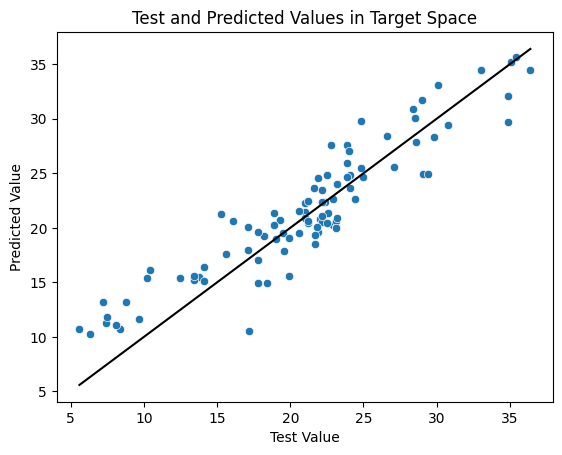

In [85]:
g =sns.scatterplot(x = y_test, y = y_pred)
g = sns.lineplot(x = y_test, y = y_test, color = 'black')
g.set_ylabel('Predicted Value')
g.set_xlabel('Test Value')
g.set_title('Test and Predicted Values in Target Space')
plt.show()

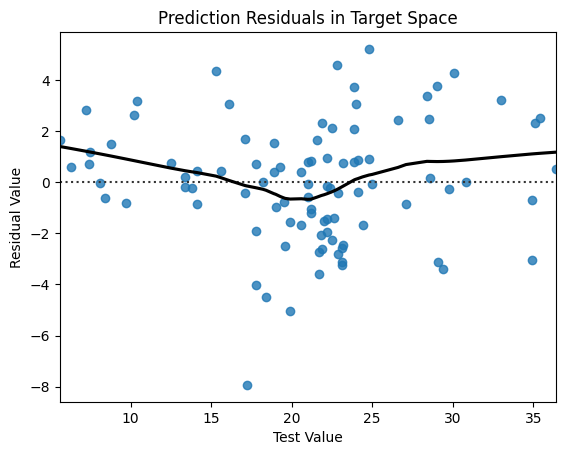

In [86]:
g = sns.residplot(x = y_test, y=y_pred, lowess=True, line_kws=dict(color = 'black'))
g.set_ylabel('Residual Value')
g.set_title('Prediction Residuals in Target Space')
g.set_xlabel('Test Value')
plt.show()

## <font color=#14F278> 3.4 Analysis Between Task 2 and 3:</font>


In [ ]:
# Comparison 
def random_state_tester(rs_start = 0, rs_end = 10, sk_min_samples_leaf = 1, sk_max_depth = 3, sk_learning_rate = 0.1, sk_n_estimators = 100, our_min_samples_leaf = 1, our_max_depth = 3, our_learning_rate = 0.1, our_n_estimators = 100):
    # Initialize lists for sklearn's and our r2 and MSE scores
    sk_r2 = []
    our_r2 = []
    sk_mse = []
    our_mse = []
    for i in range(rs_start, rs_end): 
        # Perform train-test-split on specific random state (sklearn train-test-split used for reproduceability across machines)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        # sklearn model initalized with parameters to match function inputs 
        sk_model = GradientBoostingRegressor(min_samples_leaf= sk_min_samples_leaf, max_depth=sk_max_depth, learning_rate= sk_learning_rate, n_estimators= sk_n_estimators)
        sk_model.fit(X_train, y_train)  # sklearn model fit on training data
        sk_y_pred = sk_model.predict(X_test) # sklearn model predicts from X_test
        sk_r2.append(r2_score(y_test, sk_y_pred)) # sklearn r2 score added to list
        sk_mse.append(mean_squared_error(y_test, sk_y_pred)) # sklearn MSE score added to list
        # our model initalized with parameters to match function inputs
        our_model = GradientBoostAll(min_samples_leaf = our_min_samples_leaf, max_depth=our_max_depth, learning_rate=our_learning_rate, n_estimators=our_n_estimators)
        our_model.fit((X_train), (y_train)) #our model fit on training data
        our_y_pred = our_model.predict((X_test)) #our model predicts from X_test
        our_r2.append(my_r2((y_test), our_y_pred)) #our r2 score added to list
        our_mse.append(my_mse((y_test), our_y_pred)) #our MSE added to list
    print(f'sklearn r2: {np.mean(sk_r2)}') # sklearn model's average r2
    print(f'sklearn MSE: {np.mean(sk_mse)}') # sklearn model's average MSE
    print(f'our r2: {np.mean(our_r2)}') # our model's average r2
    print(f'our MSE: {np.mean(our_mse)}') # our model's average MSE
    print(f'difference in r2: {np.mean(sk_r2) - np.mean(our_r2)} ') # difference in average r2's
    print(f'difference in MSE: {np.mean(sk_mse)-np.mean(our_mse)}') # difference in average MSE's


random_state_tester(0,25)

sklearn r2: 0.7894932742850136
sklearn MSE: 8.279827173892215
our r2: 0.7879570863448084
our MSE: 8.338593770290382
difference in r2: 0.0015361879402051581 
difference in MSE: -0.058766596398166726


### These results show that our model matches sklearn's quite closely - we have an r2 score that is on average only 0.0015 worse than sklearn's implementation, and an MSE that is only 0.06 worse on average (recall that lower MSE is better). Note that these results may be slightly skewed by the fact that both models have not tuned for hyperparameters, and that we are simply passing the best hyperparameters from our previous grid search of each model. (The code could be easily modified to run a grid search CV on each model, however this would take quite a bit of time to run.) Nonetheless, this showcases how our implementation of gradient boosting closely matches sklearn's in terms of performance. 

# Conclusion:

## <font color=14F278> 4.1 Overall results</font>
### write here

## <font color=14F278> 4.2 Knowledge Gained</font>
### write here

## <font color=14F278> 4.3 Areas for Improvement</font>
### - Optimizing our grid search as it currently takes about an hour to run, nested for loops are not computationally efficient. Looking into random search instead of grid search could be another solution.
### - A random state that can be stored across machines, similar to sklearn
### - Our Gridsearch CV would have errors when trying to accept a model instance, would require future debugging

##### All of our code is available in our GitHub Repository JPM-Team-Yang (link: https://github.com/emmabland/JPM-Team-Yang), and all of our custom functions and classes are in clean .py files ready for packaging with PyPi or other software. 